<a href="https://colab.research.google.com/github/MGomezN/cicese_ert_escuela_verano_2022/blob/main/stg_filter_analysis_initial_settings_EarthImager.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Librerías

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import copy
import numpy as np


# Función para leer datos stg y aplicarles diferentes filtros

In [2]:
def stg_initial_settings_filters(name,name_crs,MinVoverI,MinVoltage,MaxRepeatErr,MaxAppRes,MinAppRes, MaxContactRes):
  ''' Función para leer datos stg y verificar qué datos se pierden al aplicar diferentes filtros en los "sttings iniciales" de Earth Imager'''
  # Para extraer el nombre del transecto y agregarlo automáticamente a los títulos de los plots
  survey_name=name.split('/')[-1]
  survey_name_crs=name_crs.split('/')[-1]

  # Estos nombres van de acuerdo a lo que especifique el fabricante
  columns = [
          'data_number', #data record number
          'USER', 
          'date',
          'time',
          'V/I',
          'error_rep',
          'I_mA', #Output current in mA
          'apres',
          'command file identifier', 
          'XA',
          'Y-coordinate for the A-electrode',
          'Z-coordinate for the A-electrode',
          'XB',
          'Y-coordinate for the B-electrode',
          'Z-coordinate for the B-electrode',
          'XM',
          'Y-coordinate for the M-electrode',
          'Z-coordinate for the M-electrode',
          'XN',
          'Y-coordinate for the N-electrode',
          'Z-coordinate for the N-electrode'
      ]

  stg_crudo_solo = pd.read_csv(name, skiprows=3, header=None, names=columns)

  stg_crudo_solo.head()

  # Contact resistance
   ### "A contact resistance value of over 10,000 Ohms is a clear sign of a poorly installed
   ### electrode which often leads to unacceptable data quality. An acceptable contact resistance value
   ### is often below 5000 Ohms, ideally below 2000 Ohms." Earth Imager manual.

  columns = ['RecNo', 'Vcode',
  'Curr', 'Res', 'Date','Time_crs',
  'AddrA', 'AddrB', 'Ax', 'Ay', 'Az',
  'Bx', 'By', 'Bz']
  crs_crudo = pd.read_csv(name_crs, skiprows=5, header=None, names=columns)


  stg_crudo= pd.concat([stg_crudo_solo, crs_crudo], axis=1)

  print('El valor máximo en x de los electrodos es', stg_crudo.XN.max())
  stg_crudo.describe()


  stg_columnas_relevantes=stg_crudo.drop(['USER','command file identifier',
                                        
          'Y-coordinate for the A-electrode',
          'Z-coordinate for the A-electrode',  
          'Y-coordinate for the B-electrode',
          'Z-coordinate for the B-electrode',
          'Y-coordinate for the M-electrode',
          'Z-coordinate for the M-electrode',
          'Y-coordinate for the N-electrode',
          'Z-coordinate for the N-electrode'],axis=1)
  stg_columnas_relevantes['V_mV']= (stg_columnas_relevantes['V/I'] * ((stg_columnas_relevantes.I_mA)) )
  stg_columnas_relevantes['xp']=(stg_columnas_relevantes.XA + stg_columnas_relevantes.XB + stg_columnas_relevantes.XM + stg_columnas_relevantes.XN)/4
  stg_columnas_relevantes['n']= (stg_columnas_relevantes.XM - stg_columnas_relevantes.XA )/ (stg_columnas_relevantes.XA - stg_columnas_relevantes. XB)
  stg_columnas_relevantes['a']= np.abs((stg_columnas_relevantes.XA - stg_columnas_relevantes.XB ))
  stg_columnas_relevantes['z_pseudo']= (stg_columnas_relevantes.a)/2 + (stg_columnas_relevantes.n * stg_columnas_relevantes.a )/2


  stg_columnas_relevantes.head()

  # Filtros
  stg_columnas_relevantes_filtros = copy.deepcopy(stg_columnas_relevantes)

  print('Datos crudos')
  # Pseudosección con todos los datos completos
  fig=px.scatter(stg_columnas_relevantes, y=stg_columnas_relevantes.z_pseudo,
                x=stg_columnas_relevantes.xp, color=stg_columnas_relevantes['apres'],
                labels={'Distancia':'X [m]'},
                title="Pseudoseccion de datos crudos: %s"%survey_name,
                color_continuous_scale=px.colors.sequential.Rainbow,
                hover_name=stg_columnas_relevantes.index,
                hover_data={'AddrA','AddrB','apres','Res'}) 
  fig.update_yaxes(autorange="reversed")
  fig.update_traces(marker={'size': 20})
  fig.show()

  plt.plot(stg_columnas_relevantes.xp,-1*stg_columnas_relevantes.z_pseudo,'*')
  plt.title("Pseudoseccion de datos crudos: %s"%survey_name)
  plt.show()

  # Resistividad de contacto
  fig=px.scatter(stg_columnas_relevantes, y=stg_columnas_relevantes.Res,
                x=stg_columnas_relevantes.RecNo, color=stg_columnas_relevantes['apres'],
                labels={'Measurment':'ID []'},
                title="Resistencia de contacto: %s"%survey_name_crs,
                color_continuous_scale=px.colors.sequential.Rainbow,
                hover_name=stg_columnas_relevantes.index,
                hover_data={'AddrA','AddrB','apres'}) 
  fig.update_traces(marker={'size': 10})
  fig.show()

  # Resistividad de contacto 2
  fig=px.scatter(stg_columnas_relevantes, y=stg_columnas_relevantes.AddrB,
                x=stg_columnas_relevantes.AddrA, color=stg_columnas_relevantes['Res'],
                labels={'Measurement':'ID []'},
                title="Resistencia de contacto: %s"%survey_name_crs,
                color_continuous_scale=px.colors.sequential.Rainbow,
                hover_name=stg_columnas_relevantes.index,
                hover_data={'AddrA','AddrB'}) 
  fig.update_traces(marker={'size': 10})
  fig.show()

  print('\n')
  print('\n')
  print('Después de aplicar los filtros de acuerdo a los settings iniciales')
  print('\n')
  print('OJO, los informes aquí emplean el ID del archivo .stg, osea la primer columna del archivo stg', '\n',
  'Para el Earth Imager el número de dato será un número menos porque empieza a contar desde cero')

  # NegAppRes
    #filtro
  stg_columnas_relevantes_filtroNegAppRes = stg_columnas_relevantes_filtros[(stg_columnas_relevantes_filtros['apres'] >= 0)] # los datos que quedan después de aplicar el filtro
    #conteo de cuántos datos se van
  sum_lost_NegAppRes=len(stg_columnas_relevantes) - len(stg_columnas_relevantes_filtroNegAppRes)
    # Aviso
  print('\n')
  print('Los datos a eliminar porque las apres son negativas son:',
        stg_columnas_relevantes_filtros[(stg_columnas_relevantes_filtros['apres'] < 0)].index + 1,  'en total:', sum_lost_NegAppRes)
  print('\n')


  # V/I
    #filtro
  stg_columnas_relevantes_filtroVI = stg_columnas_relevantes_filtros[(stg_columnas_relevantes_filtros['V/I'] >= MinVoverI)] 
    #conteo de cuántos datos se van
  sum_lost_VI=len(stg_columnas_relevantes) - len(stg_columnas_relevantes_filtroVI)
    # Aviso
  print('\n')
  print('Los datos a eliminar porque son menores al mínimo V/I son:',stg_columnas_relevantes_filtros[(stg_columnas_relevantes_filtros['V/I'] < MinVoverI)].index + 1,
        'en total:', sum_lost_VI)


  # Min voltage
    #filtro
  stg_columnas_relevantes_filtroVmin = stg_columnas_relevantes_filtros[(stg_columnas_relevantes_filtros['V_mV'] >= MinVoltage)] 
    #conteo de cuántos datos se van
  sum_lost_Vmin=len(stg_columnas_relevantes) - len(stg_columnas_relevantes_filtroVmin)
    # Aviso
  print('\n')
  print('Los datos a eliminar porque están por debajo del voltaje mínimo son:',
        stg_columnas_relevantes_filtros[(stg_columnas_relevantes_filtros['V_mV'] < MinVoltage)].index + 1,  'en total:', sum_lost_Vmin)


  # MaxRepeatErr
    #filtro
  stg_columnas_relevantes_filtroMaxRepeatErr = stg_columnas_relevantes_filtros[(stg_columnas_relevantes_filtros['error_rep'] <= MaxRepeatErr)] 
    #conteo de cuántos datos se van
  sum_lost_MaxRepeatErr = len(stg_columnas_relevantes) - len(stg_columnas_relevantes_filtroMaxRepeatErr)
    # Aviso
  print('\n')
  print('Los datos a eliminar porque están por arriba del MaxRepeatErr son:',
        stg_columnas_relevantes_filtros[(stg_columnas_relevantes_filtros['error_rep'] > MaxRepeatErr)].index + 1,  'en total:', sum_lost_MaxRepeatErr)


  # MaxAppRes
    #filtro
  stg_columnas_relevantes_filtroMaxAppRes = stg_columnas_relevantes_filtros[(stg_columnas_relevantes_filtros['apres'] <= MaxAppRes)] 
    #conteo de cuántos datos se van
  sum_lost_MaxAppRes=len(stg_columnas_relevantes) - len(stg_columnas_relevantes_filtroMaxAppRes)
    # Aviso
  print('\n')
  print('Los datos a eliminar porque están por arriba del MaxAppRes son:',
        stg_columnas_relevantes_filtros[(stg_columnas_relevantes_filtros['apres'] > MaxAppRes)].index + 1,  'en total:', sum_lost_MaxAppRes)

  # MinAppRes
    #filtro
  stg_columnas_relevantes_filtroMinAppRes = stg_columnas_relevantes_filtros[(stg_columnas_relevantes_filtros['apres'] >= MinAppRes)] 
    #conteo de cuántos datos se van
  sum_lost_MinAppRes=len(stg_columnas_relevantes) - len(stg_columnas_relevantes_filtroMinAppRes)
    # Aviso
  print('\n')
  print('Los datos a eliminar porque están por debajo del MinAppRes son:',
        stg_columnas_relevantes_filtros[(stg_columnas_relevantes_filtros['apres'] < MinAppRes)].index + 1,  'en total:', sum_lost_MinAppRes)
  print('\n')

  # ContactRes
    #filtro
  stg_columnas_relevantes_filtroContactRes = stg_columnas_relevantes_filtros[(stg_columnas_relevantes_filtros['Res'] <= MaxContactRes)] 
    #conteo de cuántos datos se van
  sum_lost_ContactRes=len(stg_columnas_relevantes) - len(stg_columnas_relevantes_filtroContactRes)
    # Aviso
  print('\n')
  print('Los datos a eliminar porque están por arriba de la MaxContactRes son:',
        stg_columnas_relevantes_filtros[(stg_columnas_relevantes_filtros['Res'] > MaxContactRes)].index + 1,  'en total:', sum_lost_ContactRes)
  print('\n')

  fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(8, 8))
  # Apres negativa:
  axs[0, 0].set_title("Apres Negativas")
  axs[0, 0].plot(stg_columnas_relevantes_filtroNegAppRes.xp,stg_columnas_relevantes_filtroNegAppRes.z_pseudo,'*',color='C0')
  axs[0, 0].set_xlabel("Distance [m]")
  axs[0, 0].set_ylabel("Z [m]")
  axs[0, 0].invert_yaxis()


  axs[0, 1].set_title("V/I")
  axs[0, 1].plot(stg_columnas_relevantes_filtroVI.xp,stg_columnas_relevantes_filtroVI.z_pseudo,'*',color='C0')
  axs[0, 1].set_xlabel("Distance [m]")
  axs[0, 1].set_ylabel("Z [m]")
  axs[0, 1].invert_yaxis()

  axs[1, 0].set_title("Voltaje Min")
  axs[1, 0].plot(stg_columnas_relevantes_filtroVmin.xp,stg_columnas_relevantes_filtroVmin.z_pseudo,'*', color='C0')
  axs[1, 0].set_xlabel("Distance [m]")
  axs[1, 0].set_ylabel("Z [m]")
  axs[1, 0].invert_yaxis()

  axs[1, 1].set_title("Repeat error")
  axs[1, 1].plot(stg_columnas_relevantes_filtroMaxRepeatErr.xp,stg_columnas_relevantes_filtroMaxRepeatErr.z_pseudo,'*', color='C0')
  axs[1, 1].set_xlabel("Distance [m]")
  axs[1, 1].set_ylabel("Z [m]")
  axs[1, 1].invert_yaxis()

  axs[2, 0].set_title("Min appRes")
  axs[2, 0].plot(stg_columnas_relevantes_filtroMinAppRes.xp,stg_columnas_relevantes_filtroMinAppRes.z_pseudo,'*', color='C0')
  axs[2, 0].set_xlabel("Distance [m]")
  axs[2, 0].set_ylabel("Z [m]")
  axs[2, 0].invert_yaxis()

  axs[2, 1].set_title("Max appres")
  axs[2, 1].plot(stg_columnas_relevantes_filtroMaxAppRes.xp,stg_columnas_relevantes_filtroMaxAppRes.z_pseudo,'*', color='C0')
  axs[2, 1].set_xlabel("Distance [m]")
  axs[2, 1].set_ylabel("Z [m]")
  axs[2, 1].invert_yaxis()

  axs[3, 0].set_title("Max ResContact")
  axs[3, 0].plot(stg_columnas_relevantes_filtroContactRes.xp,stg_columnas_relevantes_filtroContactRes.z_pseudo,'*', color='C0')
  axs[3, 0].set_xlabel("Distance [m]")
  axs[3, 0].set_ylabel("Z [m]")
  axs[3, 0].invert_yaxis()
  fig.suptitle("Transecto: %s"%survey_name, fontsize=16, y=1.1)


  fig.tight_layout()

  plt.show()

  # Aplicando todos los filtros a la vez:
  # V/I
    #filtro
  stg_columnas_relevantes_filtroVI = stg_columnas_relevantes_filtros[(stg_columnas_relevantes_filtros['V/I'] >= MinVoverI)] 

  # Min voltage
    #filtro
  stg_columnas_relevantes_filtroVmin = stg_columnas_relevantes_filtroVI [(stg_columnas_relevantes_filtroVI ['V_mV'] >= MinVoltage)] 

  # MaxRepeatErr
    #filtro
  stg_columnas_relevantes_filtroMaxRepeatErr = stg_columnas_relevantes_filtroVmin[(stg_columnas_relevantes_filtroVmin['error_rep'] <= MaxRepeatErr)] 

  # MaxAppRes
    #filtro
  stg_columnas_relevantes_filtroMaxAppRes = stg_columnas_relevantes_filtroMaxRepeatErr [(stg_columnas_relevantes_filtroMaxRepeatErr ['apres'] <= MaxAppRes)] 

  # MinAppRes
    #filtro
  stg_columnas_relevantes_filtroMinAppRes = stg_columnas_relevantes_filtroMaxAppRes [(stg_columnas_relevantes_filtroMaxAppRes ['apres'] >= MinAppRes)] 

  # Max Contact Resistance
    #filtro
  stg_columnas_relevantes_filtroContactRes = stg_columnas_relevantes_filtroMinAppRes [(stg_columnas_relevantes_filtroMinAppRes ['Res'] <= MaxContactRes)] 


  
  stg_columnas_relevantes_filtrostodos = copy.deepcopy(stg_columnas_relevantes_filtroContactRes)

  # # Filtrando resistividad aparente

  plt.plot(stg_columnas_relevantes_filtrostodos.data_number,stg_columnas_relevantes_filtrostodos.apres,'*')
  plt.title("Así se distribuye la resistividad aparente después de aplicar los filtros iniciales: %s"%survey_name)
  plt.xlabel('Número de dato')
  plt.ylabel('Ohm-m')
  plt.show()

  plt.hist(stg_columnas_relevantes_filtrostodos.apres)
  plt.title("Así se distribuye la resistividad aparente después de aplicar los filtros iniciales: %s"%survey_name)
  plt.xlabel('Resistividad Aparente Ohm-m')
  plt.ylabel('Cantidad de datos')
  plt.show()

  # Pseudosección con todos los datos después de todos los filtros
  fig=px.scatter(stg_columnas_relevantes_filtrostodos, y=stg_columnas_relevantes_filtrostodos.z_pseudo,
                x=stg_columnas_relevantes_filtrostodos.xp,
                color=stg_columnas_relevantes_filtrostodos.apres,
                labels={'Distancia':'X [m]'},
  title="Pseudoseccion final después de filtrar: %s"%survey_name,
  color_continuous_scale=px.colors.sequential.Rainbow)
  fig.update_yaxes(autorange="reversed")
  fig.update_traces(marker={'size': 20})
  fig.show()
  plt.plot(stg_columnas_relevantes_filtrostodos.xp,-1*stg_columnas_relevantes_filtrostodos.z_pseudo,'*')
  plt.title("Pseudoseccion final después de filtrar: %s"%survey_name)
  plt.show()

  # Resistividad de contacto después de filtrar
  fig=px.scatter(stg_columnas_relevantes_filtrostodos, y=stg_columnas_relevantes_filtrostodos.Res,
                x=stg_columnas_relevantes_filtrostodos.RecNo, color=stg_columnas_relevantes_filtrostodos['apres'],
                labels={'Measurement':'ID []'},
                title="Resistencia de contacto: %s"%survey_name_crs,
                color_continuous_scale=px.colors.sequential.Rainbow,
                hover_name=stg_columnas_relevantes_filtrostodos.index,
                hover_data={'AddrA','AddrB','apres'}) 
  fig.update_traces(marker={'size': 10})
  fig.show()

  # Resistividad de contacto 2 después de filtrar
  fig=px.scatter(stg_columnas_relevantes_filtrostodos, y=stg_columnas_relevantes_filtrostodos.AddrB,
                x=stg_columnas_relevantes_filtrostodos.AddrA, color=stg_columnas_relevantes_filtrostodos['Res'],
                labels={'Measurement':'ID []'},
                title="Resistencia de contacto: %s"%survey_name_crs,
                color_continuous_scale=px.colors.sequential.Rainbow,
                hover_name = stg_columnas_relevantes_filtrostodos.index,
                hover_data={'AddrA','AddrB'}) 
  fig.update_traces(marker={'size': 10})
  fig.show()
  print("En resumen, el archivo crudo %s"%survey_name, 'tenía', len(stg_crudo),'y termina con', len(stg_columnas_relevantes_filtrostodos),'\n','Es decir, se pierden',len(stg_crudo)- len(stg_columnas_relevantes_filtrostodos),'datos.' )
  return stg_crudo
  

# Criterios para remover datos

In [3]:
MinVoverI = 0.0005  #Ohm 5x10-4
MinVoltage = 0.2
MaxRepeatErr = 120
MaxAppRes = 1000
MinAppRes = 1
MaxContactRes = 2000 #

# Líneas obtenidas en la escuela de verano CICESE

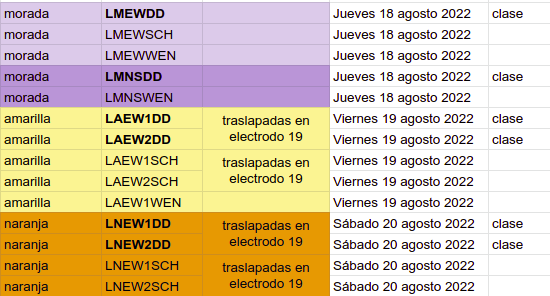

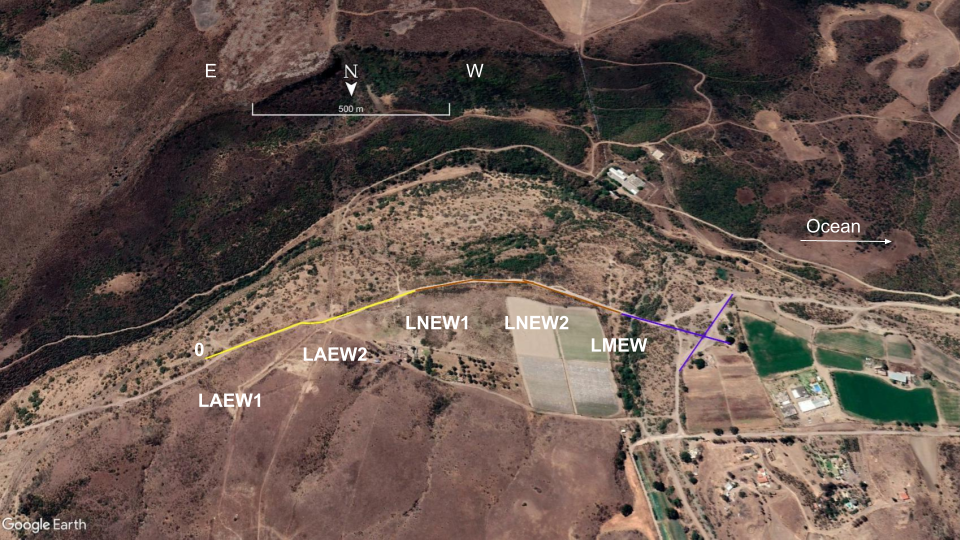

# 🟨 Dipolo - Dipolo  Lineas amarillas

El valor máximo en x de los electrodos es 270.0
Datos crudos


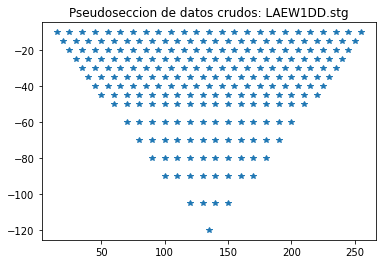





Después de aplicar los filtros de acuerdo a los settings iniciales


OJO, los informes aquí emplean el ID del archivo .stg, osea la primer columna del archivo stg 
 Para el Earth Imager el número de dato será un número menos porque empieza a contar desde cero


Los datos a eliminar porque las apres son negativas son: Int64Index([1, 100, 125, 129, 173, 199, 208, 216, 222, 227, 231, 233, 236], dtype='int64') en total: 13




Los datos a eliminar porque son menores al mínimo V/I son: Int64Index([1, 36, 100, 125, 129, 173, 199, 208, 216, 222, 227, 231, 233, 236], dtype='int64') en total: 14


Los datos a eliminar porque están por debajo del voltaje mínimo son: Int64Index([  1,  20,  21,  29,  32,  33,  34,  35,  36,  43,  44,  47,  48,
             49,  50,  61,  62,  63,  76,  77,  78, 100, 125, 129, 173, 199,
            208, 216, 222, 227, 231, 233, 236],
           dtype='int64') en total: 33


Los datos a eliminar porque están por arriba del MaxRepeatErr son: Int64Index([], dtype=

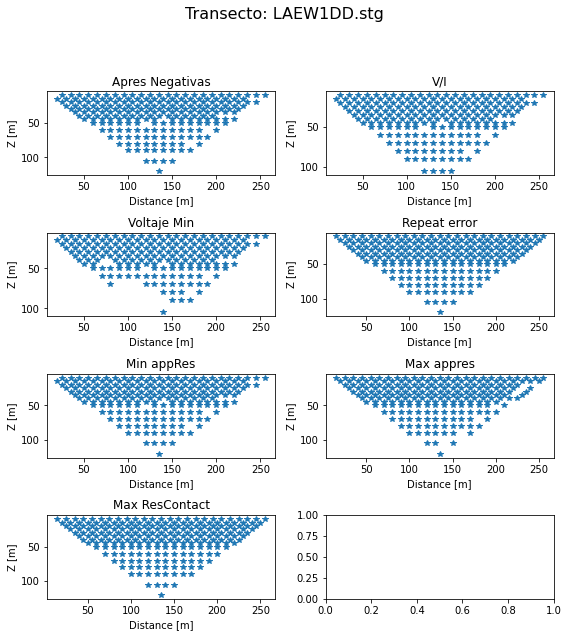

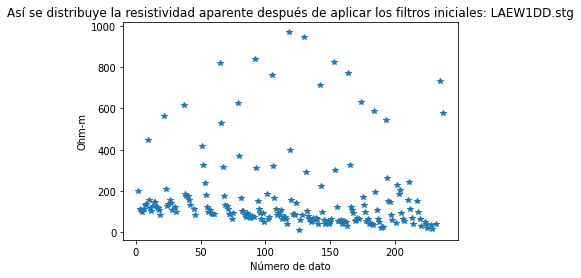

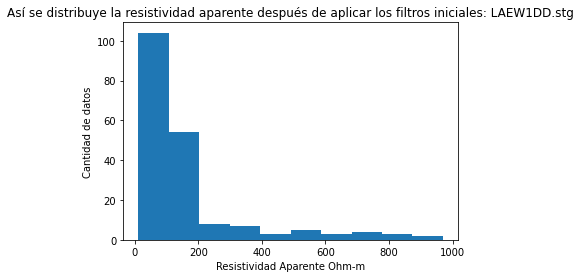

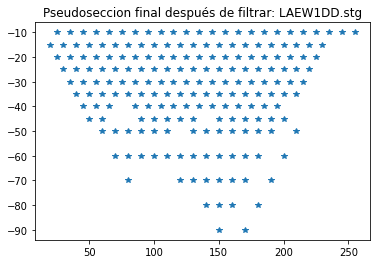

En resumen, el archivo crudo LAEW1DD.stg tenía 237 y termina con 193 
 Es decir, se pierden 44 datos.


,data_number,USER,date,time,V/I,error_rep,I_mA,apres,command file identifier,XA,...,Date,Time_crs,AddrA,AddrB,Ax,Ay,Az,Bx,By,Bz
0,1,USER,20220819,12:42:59,-0.885954,3,256,-166.9980,LAEW1DD,10.0,...,20220819,12:42:59,2,1,10.0,0.0,0.0,0.0,0.0,0.0
1,2,USER,20220819,12:43:14,0.264351,0,92,199.3160,LAEW1DD,10.0,...,20220819,12:43:14,2,1,10.0,0.0,0.0,0.0,0.0,0.0
2,3,USER,20220819,12:43:28,0.058611,1,92,110.4790,LAEW1DD,10.0,...,20220819,12:43:28,2,1,10.0,0.0,0.0,0.0,0.0,0.0
3,4,USER,20220819,12:43:42,0.028455,1,91,107.2720,LAEW1DD,10.0,...,20220819,12:43:42,2,1,10.0,0.0,0.0,0.0,0.0,0.0
4,5,USER,20220819,12:43:57,0.014640,7,91,96.5834,LAEW1DD,10.0,...,20220819,12:43:57,2,1,10.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
232,233,USER,20220819,13:45:01,-3.394230,2,922,-2559.1900,LAEW1DD,230.0,...,20220819,13:45:01,24,23,230.0,0.0,0.0,220.0,0.0,0.0
233,234,USER,20220819,13:45:15,3.229190,1,922,6086.8700,LAEW1DD,230.0,...,20220819,13:45:15,24,23,230.0,0.0,0.0,220.0,0.0,0.0
234,235,USER,20220819,13:45:42,3.894010,7,696,734.0040,LAEW1DD,240.0,...,20220819,13:45:42,25,24,240.0,0.0,0.0,230.0,0.0,0.0
235,236,USER,20220819,13:46:08,-3.487690,7,696,-2629.6600,LAEW1DD,240.0,...,20220819,13:46:08,25,24,240.0,0.0,0.0,230.0,0.0,0.0


In [4]:
LAEW1DD=r'/content/drive/MyDrive/Colab Notebooks/mariana_escuela_verano_2022_EarthImager_mariana/LA/LAEW1DD.stg'
LAEW1DDcrs=r'/content/drive/MyDrive/Colab Notebooks/mariana_escuela_verano_2022_EarthImager_mariana/LA/LAEW1DD.crs'
stg_initial_settings_filters(LAEW1DD,LAEW1DDcrs,MinVoverI,MinVoltage,MaxRepeatErr,MaxAppRes,MinAppRes,MaxContactRes)

In [6]:
stg_initial_settings_filters(LAEW1DD,LAEW1DDcrs,MinVoverI,MinVoltage,MaxRepeatErr,MaxAppRes,MinAppRes)

TypeError: ignored

In [ ]:
LAEW1SCH = r'/content/drive/MyDrive/Colab Notebooks/mariana_escuela_verano_2022_EarthImager_mariana/LA/LAEW1SCH.stg'
stg_initial_settings_filters(LAEW1SCH,MinVoverI,MinVoltage,MaxRepeatErr,MaxAppRes,MinAppRes)

In [ ]:
LAEW1WEN = r'/content/drive/MyDrive/Colab Notebooks/mariana_escuela_verano_2022_EarthImager_mariana/LA/LAEW1WEN.stg'
stg_initial_settings_filters(LAEW1WEN ,MinVoverI,MinVoltage,MaxRepeatErr,MaxAppRes,MinAppRes)

In [ ]:
LAEW2DD=r'/content/drive/MyDrive/Colab Notebooks/mariana_escuela_verano_2022_EarthImager_mariana/LA/LAEW2DD.stg'
stg_initial_settings_filters(LAEW2DD,MinVoverI,MinVoltage,MaxRepeatErr,MaxAppRes,MinAppRes)

In [ ]:
LAEW2SCH = r'/content/drive/MyDrive/Colab Notebooks/mariana_escuela_verano_2022_EarthImager_mariana/LA/LAEW2SCH.stg'
stg_initial_settings_filters(LAEW2SCH,MinVoverI,MinVoltage,MaxRepeatErr,MaxAppRes,MinAppRes)

# 🟧 Dipolo - Dipolo  Lineas naranjas



In [ ]:
LNEW1DD=r'/content/drive/MyDrive/Colab Notebooks/mariana_escuela_verano_2022_EarthImager_mariana/LN/LNEW1DD.stg'
stg_initial_settings_filters(LNEW1DD,MinVoverI,MinVoltage,MaxRepeatErr,MaxAppRes,MinAppRes)

In [ ]:
LNEW1SCH=r'/content/drive/MyDrive/Colab Notebooks/mariana_escuela_verano_2022_EarthImager_mariana/LN/LNEW1SCH.stg'
stg_initial_settings_filters(LNEW1SCH,MinVoverI,MinVoltage,MaxRepeatErr,MaxAppRes,MinAppRes)

In [ ]:
LNEW2DD=r'/content/drive/MyDrive/Colab Notebooks/mariana_escuela_verano_2022_EarthImager_mariana/LN/LNEW2DD.stg'
stg_initial_settings_filters(LNEW2DD,MinVoverI,MinVoltage,MaxRepeatErr,MaxAppRes,MinAppRes)

In [ ]:
LNEW2SCH=r'/content/drive/MyDrive/Colab Notebooks/mariana_escuela_verano_2022_EarthImager_mariana/LN/LNEW2SCH.stg'
stg_initial_settings_filters(LNEW2SCH,MinVoverI,MinVoltage,MaxRepeatErr,MaxAppRes,MinAppRes)

# 🟪  Dipolo - Dipolo  Lineas moradas

In [ ]:
LMEWDD_Reversed=r'/content/drive/MyDrive/Colab Notebooks/mariana_escuela_verano_2022_EarthImager_mariana/LM/LMEWDD_Reversed.stg'
stg_initial_settings_filters(LMEWDD_Reversed,MinVoverI,MinVoltage,MaxRepeatErr,MaxAppRes,MinAppRes)

In [ ]:
LMEWSCH_Reversed = r'/content/drive/MyDrive/Colab Notebooks/mariana_escuela_verano_2022_EarthImager_mariana/LM/LMEWSCH_Reversed.stg'
stg_initial_settings_filters(LMEWSCH_Reversed,MinVoverI,MinVoltage,MaxRepeatErr,MaxAppRes,MinAppRes)

In [ ]:
LMEWWEN_Reversed = r'/content/drive/MyDrive/Colab Notebooks/mariana_escuela_verano_2022_EarthImager_mariana/LM/LMEWWEN_Reversed.stg'
stg_initial_settings_filters(LMEWWEN_Reversed ,MinVoverI,MinVoltage,MaxRepeatErr,MaxAppRes,MinAppRes)

In [ ]:
LMNSDD=r'/content/drive/MyDrive/Colab Notebooks/mariana_escuela_verano_2022_EarthImager_mariana/LM/LMNSDD.stg'
stg_initial_settings_filters(LMNSDD,MinVoverI,MinVoltage,MaxRepeatErr,MaxAppRes,MinAppRes)

In [ ]:
LMNSWEN=r'/content/drive/MyDrive/Colab Notebooks/mariana_escuela_verano_2022_EarthImager_mariana/LM/LMNSWEN.stg'
stg_initial_settings_filters(LMNSWEN,MinVoverI,MinVoltage,MaxRepeatErr,MaxAppRes,MinAppRes)

# Resistencias de contacto

In [ ]:
name_crs=r'/content/drive/MyDrive/Colab Notebooks/mariana_escuela_verano_2022_EarthImager_mariana/crs/LAEW1DD.crs'


In [ ]:
columns = ['RecNo', 'Vcode',
'Curr', 'Res', 'Date','Time',
'AddrA', 'AddrB', 'Ax', 'Ay', 'Az',
'Bx', 'By', 'Bz']
crs_crudo = pd.read_csv(name_crs, skiprows=5, header=None, names=columns)





In [ ]:
crs_crudo

In [ ]:
print('El valor máximo en x de los electrodos es', stg_crudo.XN.max())
  stg_crudo.describe()


  stg_columnas_relevantes=stg_crudo.drop(['USER','command file identifier',
                                        
          'Y-coordinate for the A-electrode',
          'Z-coordinate for the A-electrode',  
          'Y-coordinate for the B-electrode',
          'Z-coordinate for the B-electrode',
          'Y-coordinate for the M-electrode',
          'Z-coordinate for the M-electrode',
          'Y-coordinate for the N-electrode',
          'Z-coordinate for the N-electrode'],axis=1)
  stg_columnas_relevantes['V_mV']= (stg_columnas_relevantes['V/I'] * ((stg_columnas_relevantes.I_mA)) )
  stg_columnas_relevantes['xp']=(stg_columnas_relevantes.XA + stg_columnas_relevantes.XB + stg_columnas_relevantes.XM + stg_columnas_relevantes.XN)/4
  stg_columnas_relevantes['n']= (stg_columnas_relevantes.XM - stg_columnas_relevantes.XA )/ (stg_columnas_relevantes.XA - stg_columnas_relevantes. XB)
  stg_columnas_relevantes['a']= np.abs((stg_columnas_relevantes.XA - stg_columnas_relevantes.XB ))
  stg_columnas_relevantes['z_pseudo']= (stg_columnas_relevantes.a)/2 + (stg_columnas_relevantes.n * stg_columnas_relevantes.a )/2


  stg_columnas_relevantes.head()

  # Filtros
  stg_columnas_relevantes_filtros = copy.deepcopy(stg_columnas_relevantes)
  # Pseudosección con todos los datos completos
  fig=px.scatter(stg_columnas_relevantes, y=stg_columnas_relevantes.z_pseudo,
                x=stg_columnas_relevantes.xp, color=stg_columnas_relevantes['apres'],
                labels={'Distancia':'X [m]'},
                title="Pseudoseccion de datos crudos: %s"%survey_name,
                color_continuous_scale=px.colors.sequential.Rainbow) 
  fig.update_yaxes(autorange="reversed")
  fig.update_traces(marker={'size': 20})
  fig.show()

  plt.plot(stg_columnas_relevantes.xp,-1*stg_columnas_relevantes.z_pseudo,'*')
  plt.title("Pseudoseccion de datos crudos: %s"%survey_name)
  plt.show()

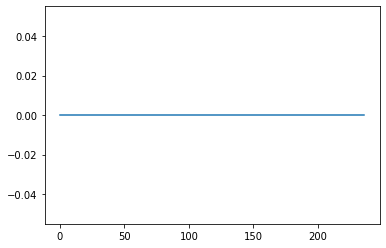

In [5]:
amarillo_crudo['time'] = pd.to_datetime(amarillo_crudo['time'])
amarillo_crudo['Time_crs'] = pd.to_datetime(amarillo_crudo['Time_crs'])
amarillo_crudo['check'] = amarillo_crudo['time'] - amarillo_crudo['Time_crs']
plt.plot(amarillo_crudo['check'])